In [5]:
import os
print(os.environ.get('OPENBLAS_NUM_THREADS'))

None


In [8]:
### Import useful libraries


import fireworks
from fireworks.ic import ic_two_body as ic_two_body

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg

import matplotlib.pyplot as plt
import numpy as np

import multiprocessing
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool


## Functions needed

def initialise(mass1=2, mass2=1, rp=2, e=0):
    particles = ic_two_body(mass1, mass2, rp, e)

    a = rp / (1 - e)  # Semi-major axis
    period = 2 * np.pi * np.sqrt(a**3 / (mass1 + mass2))

    return particles, period


def simulate(int_part,tstep=0.01,total_time = 10):

   
   integrator, particles = int_part

   integrator_name = integrator.__name__
   print("integrator_name: ", integrator_name)

   acc_list       = np.array([])
   pos_list       = np.array([])
   vel_list       = np.array([])
   kinetic_list   = np.array([])
   potential_list = np.array([])
   energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      particles, tstep, acc, jerk, _ = integrator(particles=particles, 
                                               tstep=tstep, 
                                               acceleration_estimator=dyn.acceleration_direct_vectorized,
                                               softening=0.1,
                                               )
      
      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, particles.pos)
      vel_list = np.append(vel_list, particles.vel)

      kinetic_list   = np.append(kinetic_list, particles.Ekin())
      potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      energy_list    = np.append(energy_list, particles.Etot(softening=0.1))


   acc_list = acc_list.reshape(int(total_time/tstep), 2, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), 2, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), 2, 3)

   return {"integrator_name": integrator_name,"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list, "energy_list": energy_list}
      



# key is what you want to plot, simulation_data is the output of integration_loop function
def plot_sim(key: str, simulation_data: dict):

    # Get the list of integrators from the simulation_data dictionary
    integrators = list(simulation_data.keys())

    # Create a grid plot with subplots for each integrator figsize=(8, 6 * len(integrators)
    fig, axs = plt.subplots(len(integrators)//2, len(integrators)//2)

    # Iterate over each integrator and plot pos_list
    for i, integrator in enumerate(integrators):
        data = simulation_data[integrator][key]

        for j in range(data.shape[1]):
            axs[i].scatter(data[:, j, 0], data[:, j, 1], label=f"Body {j}",s=.5)
           # axs[i].plot(data[:, 1, 0], data[:, 1, 1], label="Star 2")
            axs[i].set_title(integrator)
            axs[i].legend()

        


    plt.show()





def parallel_evo(integrators,particles):
    
    #### MULTIPROCESSING ####
    # define the number of processes
    N_CORES = multiprocessing.cpu_count() # in my case 4 cores
    N_INTEGRATORS = len(integrators)
    # start a timer
    #start = time.time()
    
    # how does it know N_particles? Lol
    N_PROCESSES = min(N_CORES, N_INTEGRATORS)
    # create a pool of processes
    pool = Pool()


    # submit multiple instances of the function full_evo 
    # - starmap_async: allows to run the processes with a (iterable) list of arguments
    # - map_async    : is a similar function, supporting a single argument

    future_results = pool.map(simulate, [(integrator,particles) for integrator in integrators])

    # to get the results all processes must have been completed
    # the get() function is therefore _blocking_ (equivalent to join) 
    #results = future_results.get()
    results = future_results

    # close the pool
    # Warning multiprocessing.pool objects have internal resources that need to be properly managed 
    # (like any other resource) by using the pool as a context manager or by calling close() and terminate() manually. Failure to do this can lead to the process hanging on finalization.
    pool.close()

    return results




In [9]:
particles, period = initialise(mass1=1, mass2=1, rp=1, e=0)

integrators = [intg.integrator_euler,
                intg.integrator_hermite,
                intg.integrator_leapfrog,
                intg.integrator_heun,
                intg.integrator_rk4,
                ]

results = parallel_evo(integrators,particles)
    
print("results: ", results)

NameError: name 'Pool' is not defined

In [10]:
results_dict = {result["integrator_name"]: result for result in results}

In [11]:
results_dict.keys()


dict_keys(['integrator_euler', 'integrator_hermite', 'integrator_leapfrog', 'integrator_heun', 'integrator_rk4'])

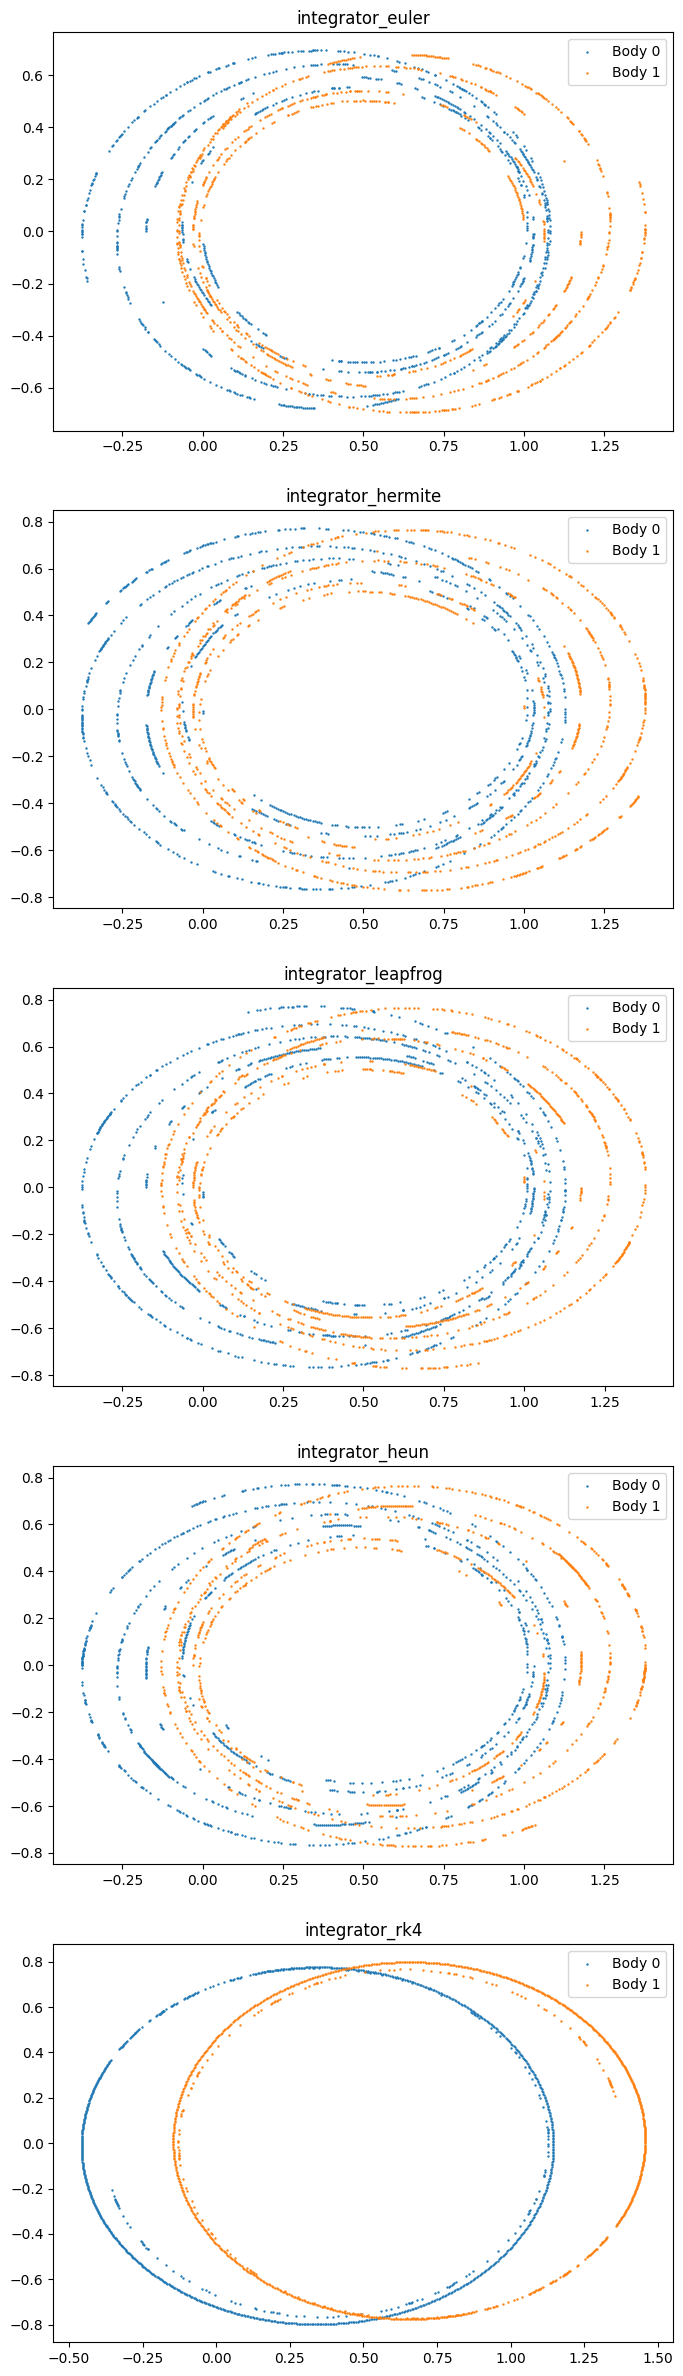

In [12]:
plot_sim("pos_list", results_dict)